In [1]:
pip install python-resize-image

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install patool

In [4]:
import patoolib
patoolib.extract_archive("C:/Users/yulyz/Desktop/CV/L2_photo.rar", outdir="C:/Users/yulyz/Desktop/CV/train_data")

patool: Extracting C:/Users/yulyz/Desktop/CV/L2_photo.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- C:\Users\yulyz\Desktop\CV\L2_photo.rar
patool:     with cwd=C:/Users/yulyz/Desktop/CV/train_data
patool: ... C:/Users/yulyz/Desktop/CV/L2_photo.rar extracted to `C:/Users/yulyz/Desktop/CV/train_data'.


'C:/Users/yulyz/Desktop/CV/train_data'

In [6]:
pip install seaborn

  Using cached pytz-2020.1-py2.py3-none-any.whl (510 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
from PIL import Image
import os

from resizeimage import resizeimage

for root, dirs, files in os.walk("C:/Users/yulyz/Desktop/CV/train_data/L2_photo/train_set/penguin"):
    for file in files:
      with open(os.path.join(root, file), 'r+b') as f:
        with Image.open(f) as image:
          cover = resizeimage.resize_cover(image, [300, 300])
          cover.save('C:/Users/yulyz/Desktop/CV/train_img/'+file, image.format)

In [11]:
import os
data_folder = 'C:/Users/yulyz/Desktop/CV/train_img'
data_set = [os.path.join(data_folder,file) for file in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder,file))]

In [12]:
def find_match_bf(img1_path, img2_path):

  img1 = cv.imread(img1_path,0)
  img2 = cv.imread(img2_path,0)

  orb = cv.ORB_create()
  # find the keypoints and descriptors with ORB
  kp1, des1 = orb.detectAndCompute(img1,None)
  kp2, des2 = orb.detectAndCompute(img2,None)

  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  # Match descriptors
  matches = bf.match(des1,des2)
  # Sort them in the order of their distance
  matches = sorted(matches, key = lambda x:x.distance)
  # plot first couple of matches (more = messier)
  img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:20],None, flags=2)
  plt.figure(figsize=(20,10))
  plt.imshow(img3)
  plt.show()

In [13]:
def find_match_flann(img1_path, img2_path, flag = True):
  MIN_MATCH_COUNT = 1
  img1 = cv2.imread(img1_path,0)
  img2 = cv2.imread(img2_path,0)

  orb = cv2.ORB_create()
  # find the keypoints and descriptors with ORB
  kp1, des1 = orb.detectAndCompute(img1,None)
  kp2, des2 = orb.detectAndCompute(img2,None)

  FLANN_INDEX_LSH = 6
  # there are some recommended values in the comments. they don't work though 🙃
  index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
  search_params = dict(checks = 50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(des1,des2,k=2)
  # store all the good matches as per Lowe's ratio test.
  good = []
  if matches:
    for m in matches:
      if len(m)>1:
        if m[0].distance < 0.7*m[1].distance:
          good.append(m[0])

  if len(good)>=MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,1.0)

    if M is None:
            return [0],[0],[0],[0],np.inf

    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    msed = np.mean([np.sqrt(np.sum(diff)) for diff in (np.power(pts-dst,2))]/(np.sqrt(h**2+w**2)))
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
  else:
    print( "Only few matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = [0]
    msed = np.inf

  draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
  if flag:
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
    plt.figure(figsize=(20,10))
    plt.imshow(img3, 'gray')
    plt.show()

  return kp1, kp2, good, matchesMask, msed

# https://docs.opencv.org/master/d1/de0/tutorial_py_feature_homography.html

In [14]:
images = [cv2.imread(image,0) for image in data_set]

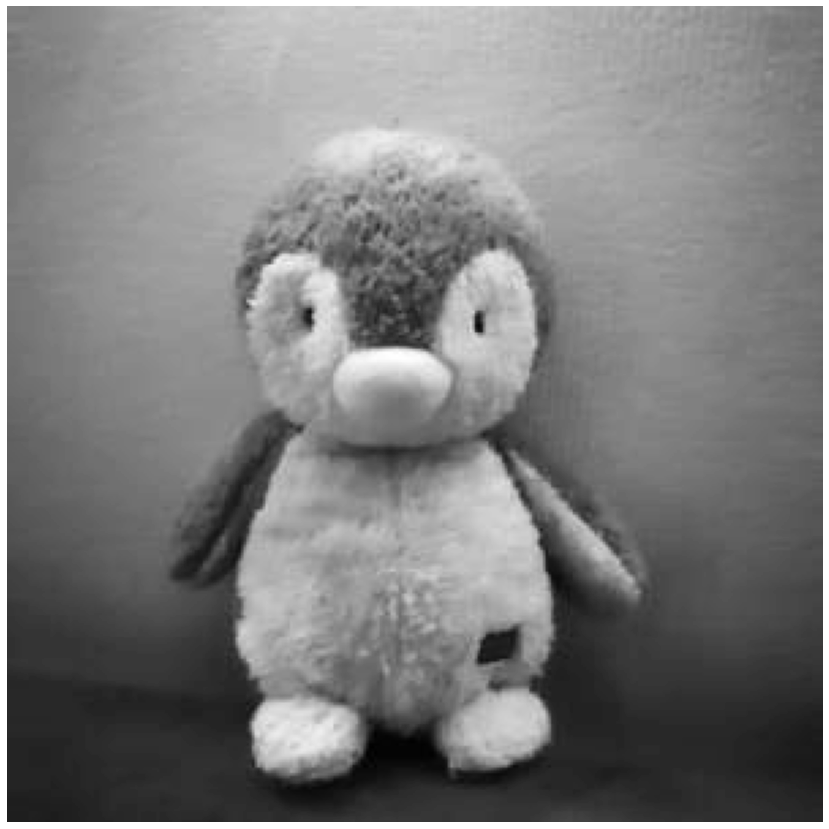

In [15]:
from random import sample 

sns.set(rc={'figure.figsize':(15,15)})

fig, ax = plt.subplots()
ax.axis("off")
plt.imshow(sample(images,1)[0], 'gray')
plt.show()

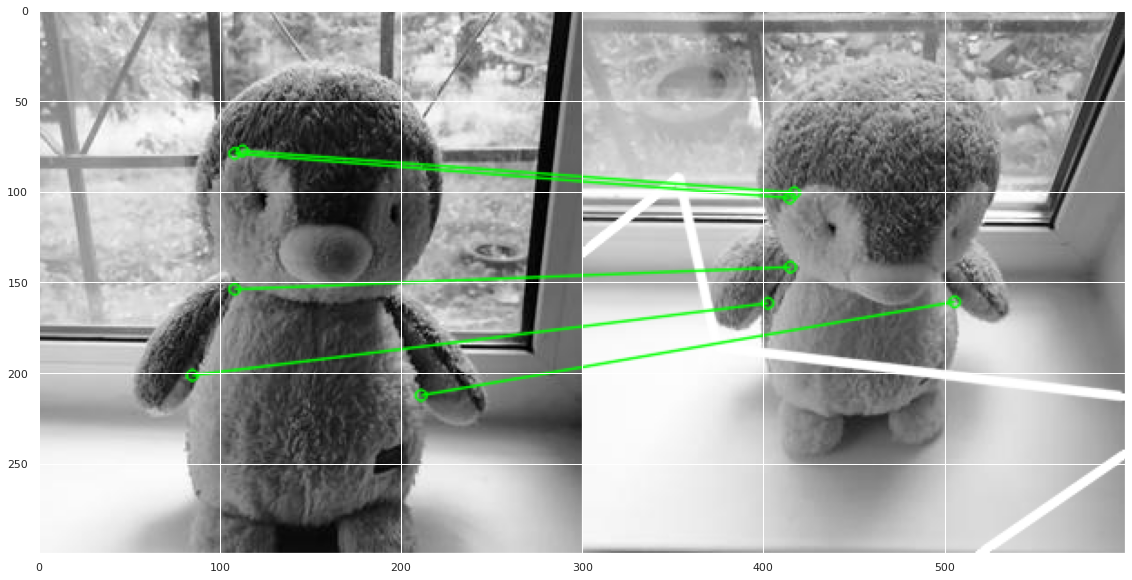

In [238]:
find_match_flann(data_set[5],data_set[12]); # good one

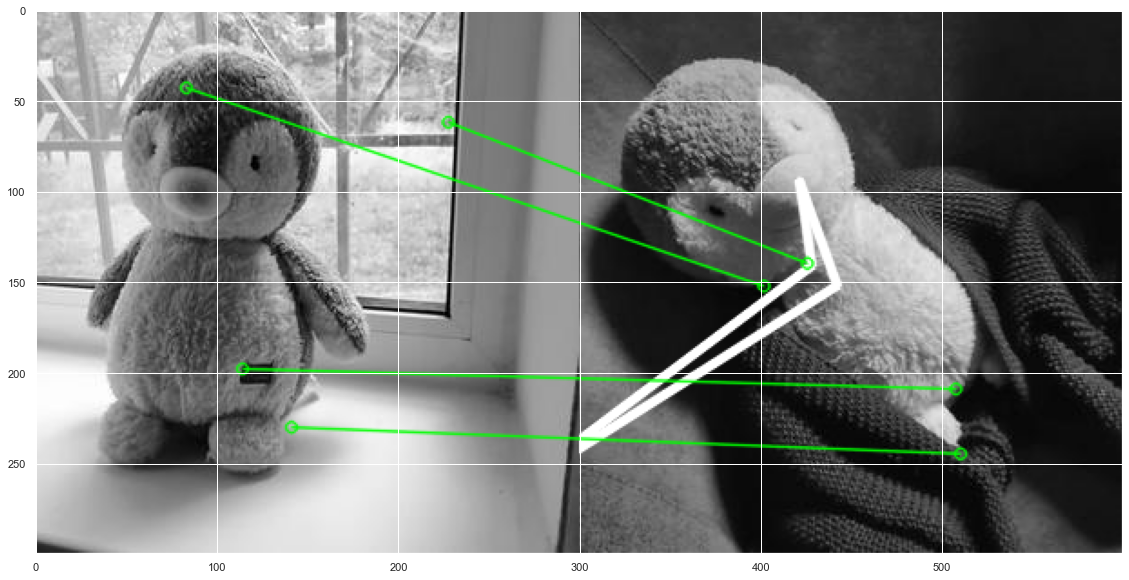

In [16]:
find_match_flann(data_set[3],data_set[95]); # bad one

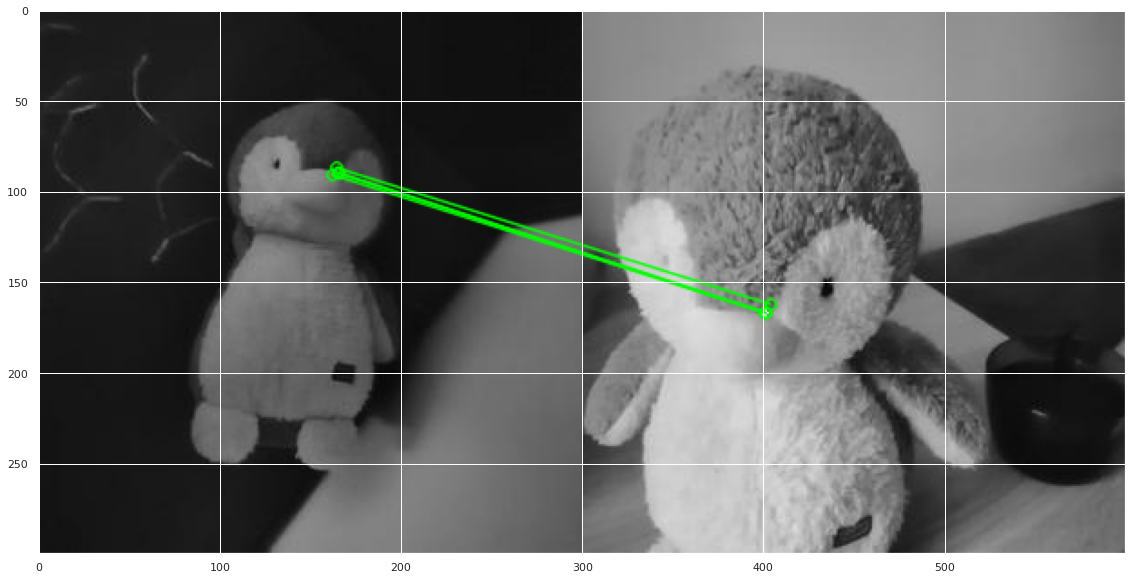

In [281]:
find_match_flann(data_set[42],data_set[105]);

In [25]:
import itertools
import time
inliers_matches = dict()
indexes = list(itertools.product(['orb'],["inliers/matches","distance MSE","time (s)"]))
for im_j_idx in data_set:
    inliers_matches["img"+str(im_j_idx)]=list()


for image_i in data_set:
    time_start=time.monotonic()
    print(image_i)
    try:
      _, __, match, inlier ,msd = find_match_flann(image_i, data_set[5], False) #5
      time_end=time.monotonic()
      if match==0:
          match=np.inf
      inliers_matches["img"+image_i].append(np.sum(inlier)/(len(match)))
      inliers_matches["img"+image_i].append(msd)
      inliers_matches["img"+image_i].append(time_end-time_start)
    except:
      inliers_matches["img"+image_i].append([0])
      inliers_matches["img"+image_i].append([0])
      inliers_matches["img"+image_i].append([0])

C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101133.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101140.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101144.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101149.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101152.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101158.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101201.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101206.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101213.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101218.jpg
Only few matches are found - 0/1
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101249.jpg


<ipython-input-25-afb08e1cde8a>:17: RuntimeWarning: invalid value encountered in long_scalars
  inliers_matches["img"+image_i].append(np.sum(inlier)/(len(match)))


C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101253.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101256.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101304.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101310.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101321.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101323.jpg
Only few matches are found - 0/1
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101326.jpg
Only few matches are found - 0/1
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101333.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101334.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101345.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101345_1.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101350.jpg
Only few matches are found - 0/1
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101354.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101400.jpg
C:/Users/yulyz/Desktop/CV/train_img\IMG_20200927_101402.jpg

In [27]:
inliers_matches

{'imgC:/Users/yulyz/Desktop/CV/train_img\\IMG_20200927_101133.jpg': [0.5714285714285714,
  0.5104023,
  0.0940000000409782],
 'imgC:/Users/yulyz/Desktop/CV/train_img\\IMG_20200927_101140.jpg': [0.0,
  inf,
  0.10899999993853271],
 'imgC:/Users/yulyz/Desktop/CV/train_img\\IMG_20200927_101144.jpg': [0.0,
  inf,
  0.0470000000204891],
 'imgC:/Users/yulyz/Desktop/CV/train_img\\IMG_20200927_101149.jpg': [0.0,
  inf,
  0.030999999959021807],
 'imgC:/Users/yulyz/Desktop/CV/train_img\\IMG_20200927_101152.jpg': [0.0,
  inf,
  0.0470000000204891],
 'imgC:/Users/yulyz/Desktop/CV/train_img\\IMG_20200927_101158.jpg': [1.0,
  3.4147567e-16,
  0.03100000019185245],
 'imgC:/Users/yulyz/Desktop/CV/train_img\\IMG_20200927_101201.jpg': [0.2647058823529412,
  0.28275394,
  0.2029999999795109],
 'imgC:/Users/yulyz/Desktop/CV/train_img\\IMG_20200927_101206.jpg': [0.2818181818181818,
  0.14282587,
  0.09399999980814755],
 'imgC:/Users/yulyz/Desktop/CV/train_img\\IMG_20200927_101213.jpg': [0.0,
  inf,
  0.047

In [28]:
import pandas as pd
index = pd.MultiIndex.from_tuples(indexes,names=['algorithm','property'])
comparison_df=pd.DataFrame(inliers_matches,index=index)

In [31]:
comparison_df.to_json('C:/Users/yulyz/Desktop/CV/lab_2.json')

В багатьох випадках, дескриптор не знаходить жодних збігів в зображенні і тому нулі зустрічаються досить часто :(

## Датасет 2

In [82]:
data_folder = 'C:/Users/yulyz/Desktop/CV/train_img_2/data'
data_set = [os.path.join(data_folder,file) for file in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder,file))]

In [83]:
images = [cv2.imread(image,0) for image in data_set]

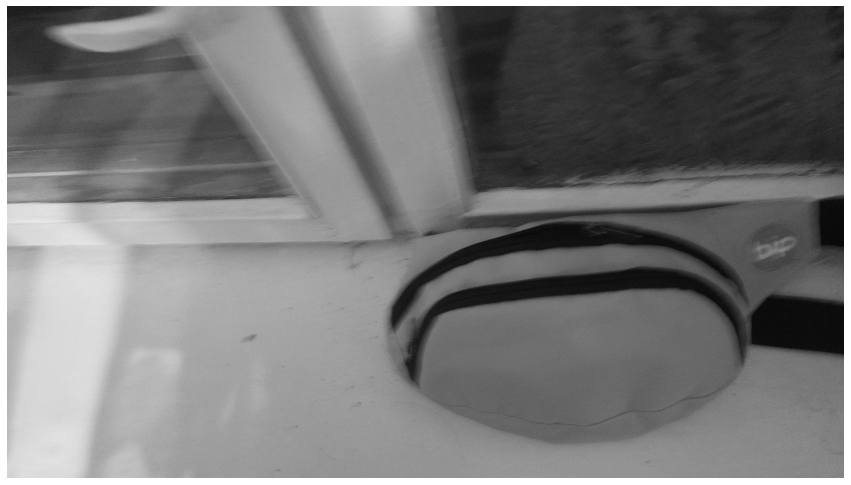

In [44]:
fig, ax = plt.subplots()
ax.axis("off")
plt.imshow(sample(images,1)[0], 'gray')
plt.show()

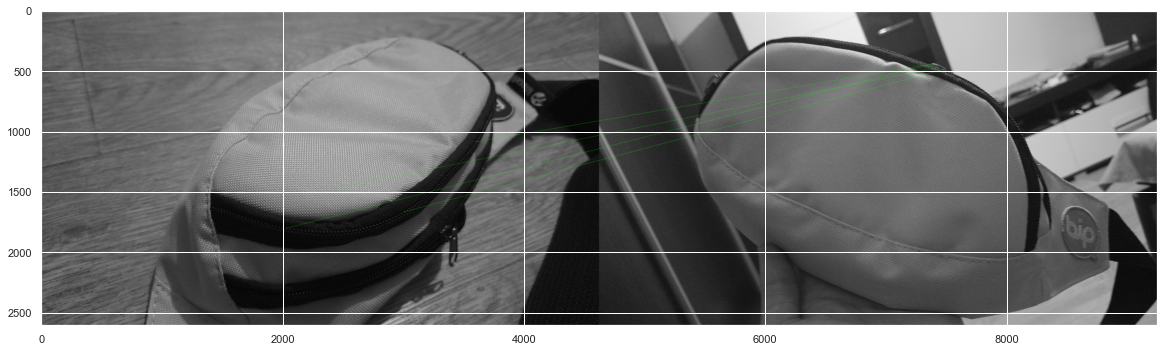

In [46]:
find_match_flann(data_set[5],data_set[10]); # good one

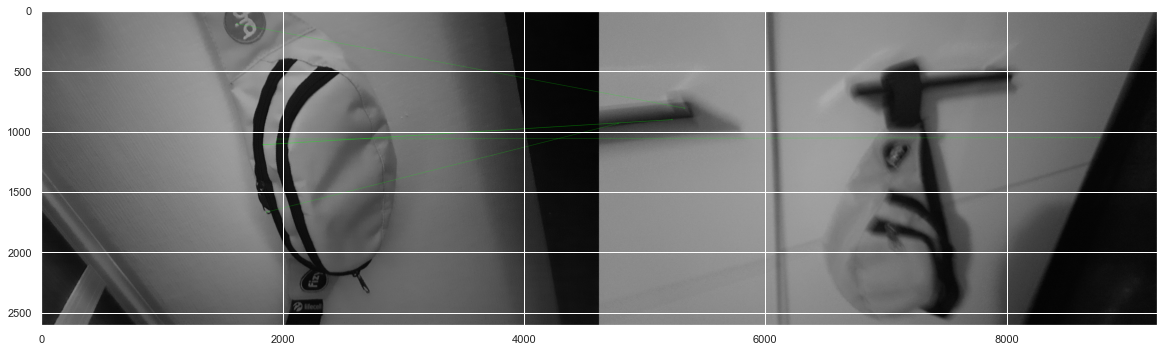

In [52]:
find_match_flann(data_set[60],data_set[50]); # bad one

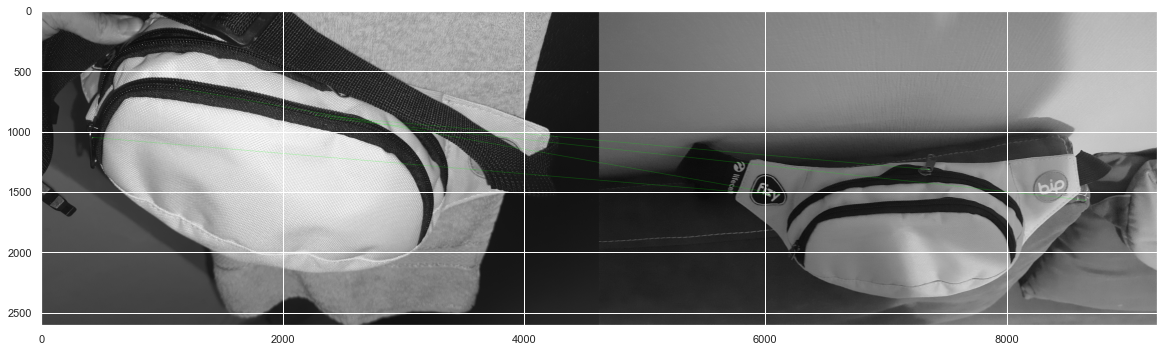

In [87]:
find_match_flann(data_set[98],data_set[66]); # medium one

Як і на наборі з пінгвінчиком, тут алгоритм показує себе не дуже добре, по тих самих причинах. Але як і в наборі з пігвінчиком, чорні виразні деталі алгоритм "відчуває". 

## Датасет 3

In [54]:
data_folder = 'C:/Users/yulyz/Desktop/CV/train_img_3/img'
data_set = [os.path.join(data_folder,file) for file in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder,file))]

In [55]:
images = [cv2.imread(image,0) for image in data_set]

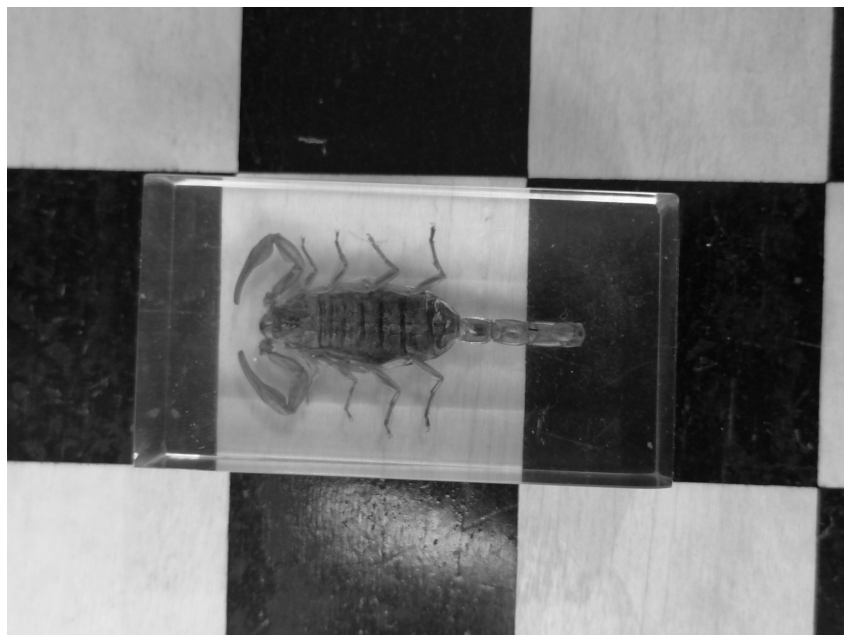

In [56]:
fig, ax = plt.subplots()
ax.axis("off")
plt.imshow(sample(images,1)[0], 'gray')
plt.show()

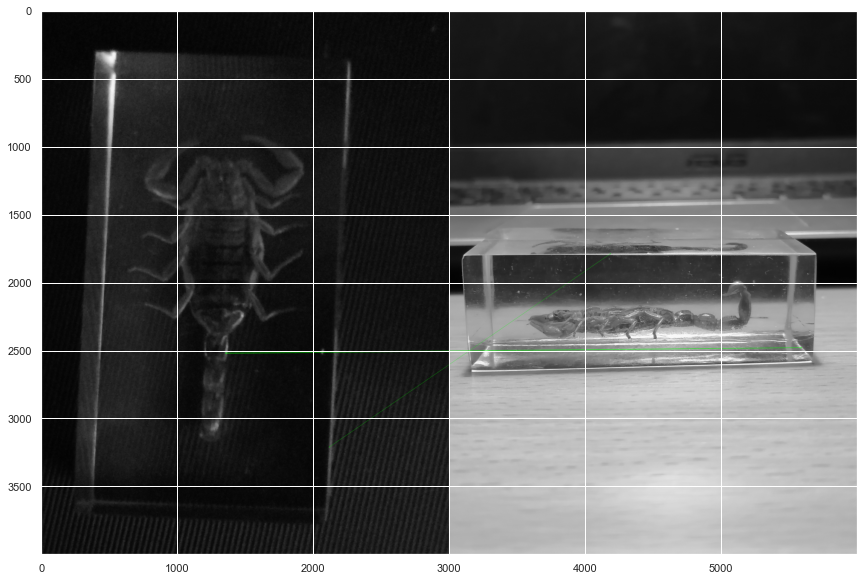

In [60]:
find_match_flann(data_set[63],data_set[50]); # very bad one (but it kinda noticed the edge so I'm gonna count it)

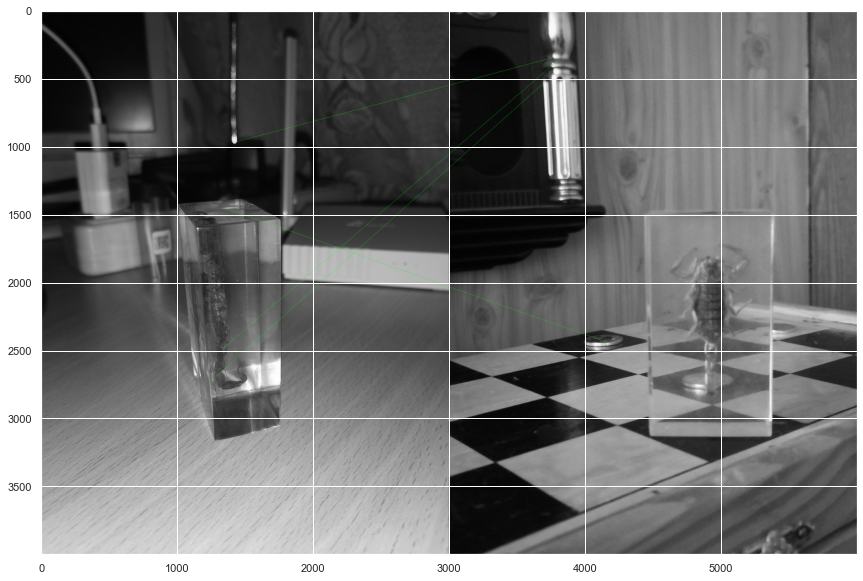

In [66]:
find_match_flann(data_set[67],data_set[97]); # even the worse one

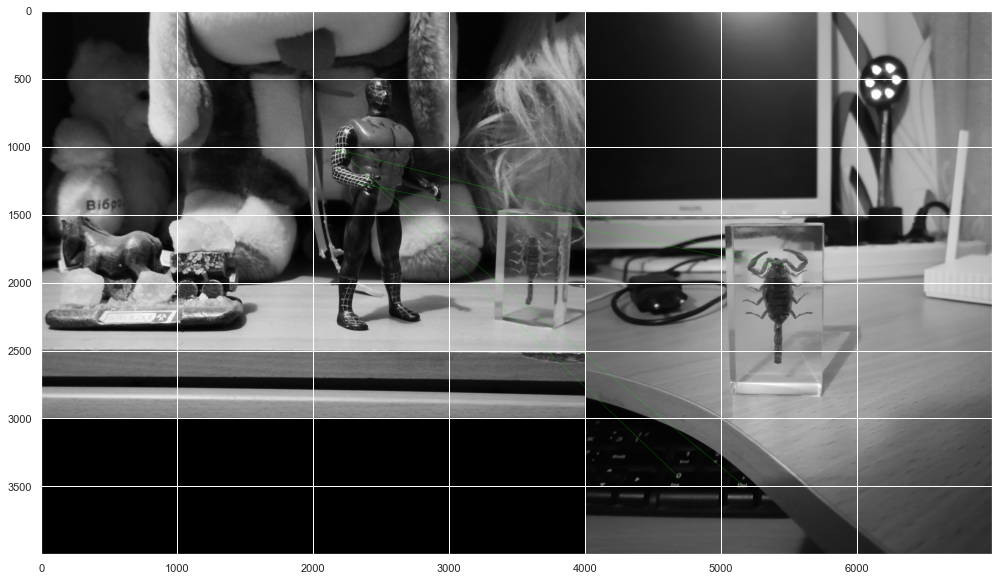

In [72]:
find_match_flann(data_set[20],data_set[15]); # oh god....

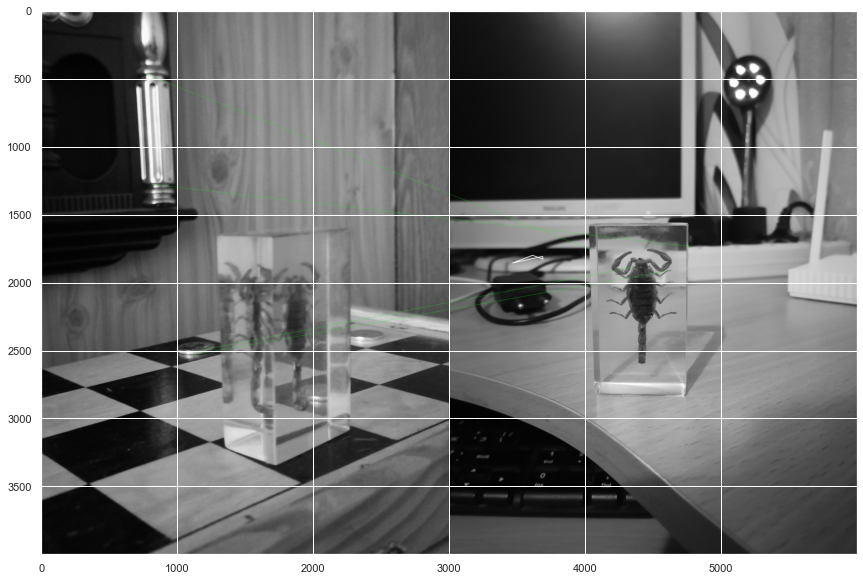

In [81]:
find_match_flann(data_set[98],data_set[15]); # well it tried

Отож і тут дескриптор показав себе погано! Навіть гірше чим в попередніх випадках. Причини: прозорість об'єкту, більший та набагато різноманітніший датасет Петра з скорпіончиком, майже завжди в кадрі багато деталей. 